In [1]:
import MDAnalysis as mda
import numpy as np
import os

In [2]:
u = mda.Universe('trajs/ld.psf','trajs/skip100.dcd')
u2 = mda.Universe('trajs/ld.psf','trajs/3mn.dcd')
u1 = mda.Universe('trajs/gro.gro','trajs/c36_skip100.xtc')
u3 = mda.Universe('trajs/gro.gro', 'trajs/c36c_skip100.xtc')

Below is just a function taken from interdigitation class.  
h[i] = Σ (mass[j] for j in bin[i])
density[i] = h[i] / (pbc[0] * pbc[1] * dz * 0.602214)


In [47]:
import numpy as np

def calculate_PL(u, water_resname='TIP3', lipid_resname='POPC DOPE', atom_name='C316'):
    halfz = u.dimensions[2] / 2
    lipid_resnames = lipid_resname.split()
    resids = u.select_atoms(' or '.join([f'resname {res} and name {atom_name}' for res in lipid_resnames]))
    # resids = u.select_atoms('resname POPC DOPE and name C316')
    upper_leaflet = resids[resids.positions[:, 2] > halfz]
    lower_leaflet = resids[resids.positions[:, 2] < halfz]
    upper_com = upper_leaflet.center_of_mass()[2]
    lower_com = lower_leaflet.center_of_mass()[2]
    # between = u.select_atoms(f"prop z > {lower_com_z} and prop z < {upper_com_z}")
    # between = u.select_atoms(f"resname TIP3 and prop z > {lower_com} and prop z < {upper_com}")
    between = u.select_atoms(f"resname {water_resname} and prop z > {lower_com} and prop z < {upper_com}")
    distance = upper_com - lower_com
    return between, distance

def density_frame(pos, mass, pbc, bins):
    dz = bins[1] - bins[0]
    h, _ = np.histogram(pos, weights=mass, bins=bins)
    h /= pbc[0]* pbc[1] * dz * 0.602214
    return h

def calculate_density(u, nbins=50, b=0, e=None, water_resname='TIP3', lipid_resname='POPC DOPE', atom_name='C316'):
    bins = np.linspace(0, u.dimensions[2], nbins+1)
    densities = []
    distances = []
    for ts in u.trajectory[b:e]:
        pbc = u.dimensions
        # atoms = u.select_atoms("resname SWM4")
        atoms, distance, = calculate_PL(u,water_resname=water_resname, lipid_resname=lipid_resname, atom_name=atom_name)
        density = density_frame(atoms.positions[:,2], atoms.masses, pbc=pbc, bins=bins)
        densities.append(density)
        distances.append(distance)
    average_density = np.mean(densities, axis=0)
    average_distance = np.mean(distances)/10
    XX = np.linspace(0, pbc[2]/10, nbins)
    results = np.column_stack((XX, average_density))
    return results, average_distance


def sum_output(output):
    return np.sum(output[:, 1])



def average_density_between_leaflets(density_data, distance):
    # Assume density_data[:, 0] is sorted in ascending order
    if not density_data.size or distance == 0:
        return 0

    # Find indices corresponding to the range between leaflets
    # Note: This assumes that the positions and distance are properly scaled in nm.
    total_density = np.trapz(density_data[:, 1], x=density_data[:, 0])
    print(total_density)
    average_density = total_density / distance  # Divide total density by the thickness of the water layer

    return average_density


import numpy as np

import numpy as np

def symmetrize(data):
    data = np.array(data)
    print(len(data))
    forw = np.array(data[:,1])
    print(len(forw))
    rev = data[::-1,1]
    print(len(rev))
    sym = (rev + forw)/2
    print(len(sym))
    return np.column_stack((data[:,0],sym))

In [30]:
results_c36, distance = calculate_density(u1,nbins=100, b=100, e=None, water_resname='TIP3',lipid_resname='POPC DOPE', atom_name='C316')
if results_c36 is not None:
    avg_density = average_density_between_leaflets(results_c36, distance)


0.03558322903750891


In [49]:
results_c36

array([[0.00000000e+00, 0.00000000e+00],
       [2.05174841e-01, 0.00000000e+00],
       [4.10349682e-01, 0.00000000e+00],
       [6.15524523e-01, 0.00000000e+00],
       [8.20699364e-01, 0.00000000e+00],
       [1.02587421e+00, 0.00000000e+00],
       [1.23104905e+00, 0.00000000e+00],
       [1.43622389e+00, 0.00000000e+00],
       [1.64139873e+00, 0.00000000e+00],
       [1.84657357e+00, 0.00000000e+00],
       [2.05174841e+00, 0.00000000e+00],
       [2.25692325e+00, 0.00000000e+00],
       [2.46209809e+00, 0.00000000e+00],
       [2.66727293e+00, 0.00000000e+00],
       [2.87244777e+00, 0.00000000e+00],
       [3.07762262e+00, 0.00000000e+00],
       [3.28279746e+00, 0.00000000e+00],
       [3.48797230e+00, 0.00000000e+00],
       [3.69314714e+00, 1.68387259e-04],
       [3.89832198e+00, 3.37487324e-04],
       [4.10349682e+00, 6.47590371e-04],
       [4.30867166e+00, 1.98770426e-03],
       [4.51384650e+00, 3.37706832e-03],
       [4.71902134e+00, 4.58655300e-03],
       [4.924196

In [48]:
sym = symmetrize(results_c36)

100
100
100
100


In [54]:
results_c36[80]

array([16.41398728,  0.        ])

In [53]:
sym[80]

array([1.64139873e+01, 1.68743662e-04])

In [174]:
# Example usage:
results_c36c, distance = calculate_density(u3,nbins=100, b=100, e=None, water_resname='TIP3',lipid_resname='POPC DOPE', atom_name='C316')
if results_c36c is not None:
    avg_density = average_density_between_leaflets(results_c36c, distance)
    print("Average Density:", avg_density, "g/cm3")
else:
    print("No data to process.")


0.0069885274864635695
Average Density: 0.0009044159697199887 g/cm3


In [198]:
results_drude0, distance = calculate_density(u2,nbins=100, b=0, e=50, water_resname='SWM4',lipid_resname='POPC DOPE', atom_name='C316')
if results_drude0 is not None:
    avg_density = average_density_between_leaflets(results_drude0, distance)

results_drude1, distance = calculate_density(u2,nbins=100, b=50, e=100, water_resname='SWM4',lipid_resname='POPC DOPE', atom_name='C316')
if results_drude1 is not None:
    avg_density = average_density_between_leaflets(results_drude1, distance)

results_drude2, distance = calculate_density(u2,nbins=100, b=100, e=150, water_resname='SWM4',lipid_resname='POPC DOPE', atom_name='C316')
if results_drude2 is not None:
    avg_density = average_density_between_leaflets(results_drude2, distance)

results_drude3, distance = calculate_density(u2,nbins=100, b=150, e=200, water_resname='SWM4',lipid_resname='POPC DOPE', atom_name='C316')
if results_drude3 is not None:
    avg_density = average_density_between_leaflets(results_drude3, distance)




0.03129840810647894
0.03242373116833423
0.03168525629442885
0.031384426019053904


In [177]:
# Example usage:
results_drude3mn, distance = calculate_density(u2,nbins=100, b=200, e=None, water_resname='SWM4',lipid_resname='POPC DOPE', atom_name='C316')
if results_drude3mn is not None:
    avg_density = average_density_between_leaflets(results_drude3mn, distance)
    print("Average Density:", avg_density, "g/cm3")
else:
    print("No data to process.")


0.030470724172581697
Average Density: 0.004407651083336575 g/cm3


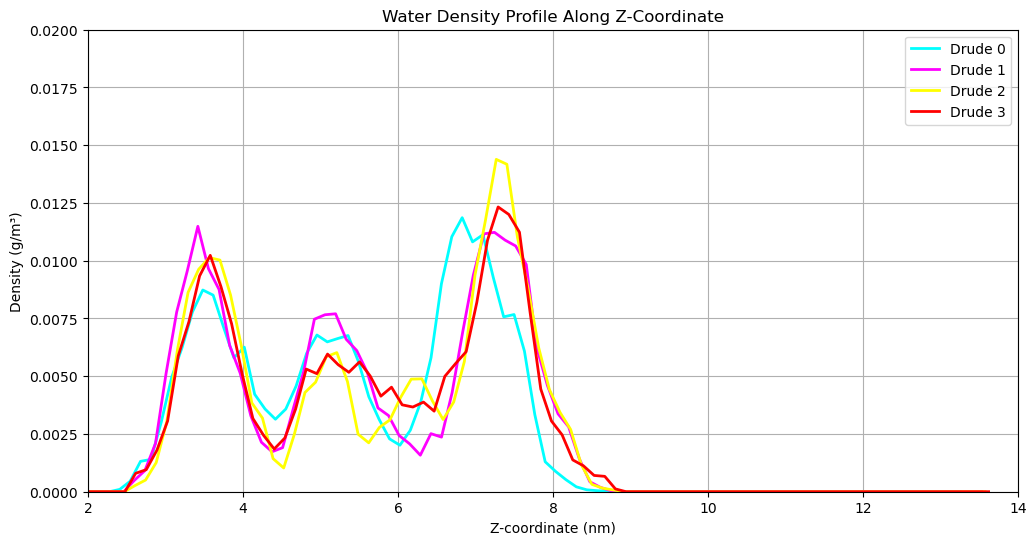

In [202]:
import matplotlib.pyplot as plt

def plot_water_density_multiple(datasets, labels=None, colors=None):
    # Create the plot
    plt.figure(figsize=(12, 6))

    for i, water_density in enumerate(datasets):
        z_coords, den_water = water_density[:, 0], water_density[:, 1]
        label = labels[i] if labels is not None else None
        color = colors[i] if colors is not None else None
        plt.plot(z_coords, den_water, label=label, color=color, linewidth=2)

    plt.title('Water Density Profile Along Z-Coordinate')
    plt.xlabel('Z-coordinate (nm)')
    plt.ylabel('Density (g/m³)')
    if labels is not None:
        plt.legend()
    plt.ylim(0, 0.02)
    plt.xlim(2, 14)
    plt.grid(True)
    plt.show()

# Assuming `results_drude3mn` is one of the datasets
# and you have other datasets like `results_drude4mn`, `results_drude5mn`
datasets = [results_drude0, results_drude1, results_drude2, results_drude3]
# labels = ['Drude 3mn', 'Drude 0mn', 'c36', 'c36c']  # Example labels
labels = ['Drude 0', 'Drude 1', 'Drude 2', 'Drude 3']  # Example labels
colors = ['cyan', 'magenta', 'yellow','red']  # Example colors

plot_water_density_multiple(datasets, labels=labels, colors=colors)


In [45]:
import matplotlib.pyplot as plt

def plot_water_density(water_density):
    # Extract z-coordinates and density values
    z_coords, den_water = water_density[:, 0], water_density[:, 1]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(z_coords, den_water, label='Water Density', color='cyan', linewidth=2)

    plt.title('Water Density Profile Along Z-Coordinate')
    plt.xlabel('Z-coordinate (nm)')
    plt.ylabel('Density (g/m³)')
    plt.legend()
    plt.ylim(0,0.02)
    plt.xlim(2,16)
    plt.grid(True)
    plt.show()


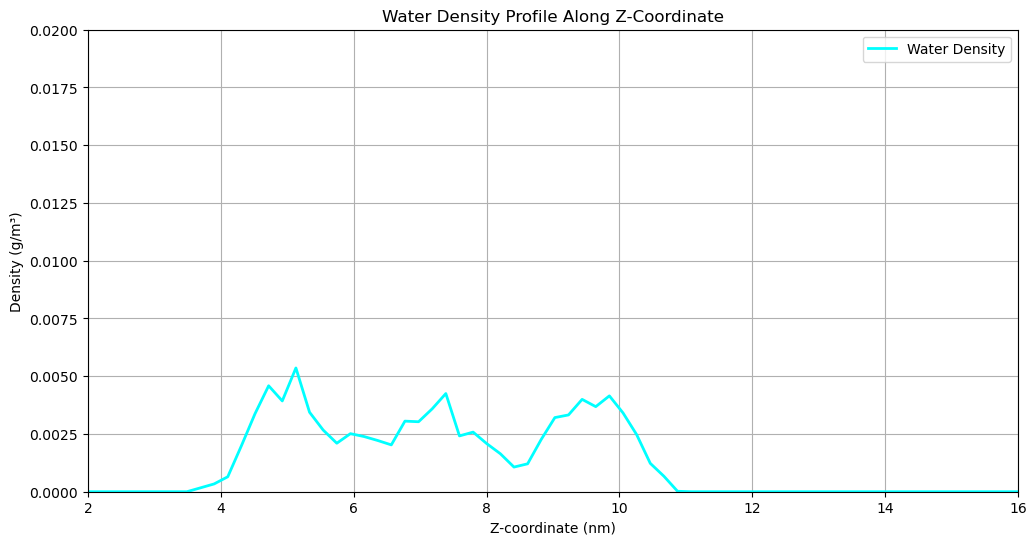

In [55]:
# Assuming `water_density_results` is the output from `calculate_water_density`
plot_water_density(results_c36)
